# Investigation and attempt to build a recommendation model for movie reviews
Data scraped from criticker.com and analysed to see what method might be best for creating a recommendation model for users based on a user who liked similar movies to you.

# Import and clean up

In [689]:
#import packages
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.layers import Concatenate, Dense, Dropout
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2
import xml.etree.ElementTree as ET
import seaborn as sns
import nbconvert
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cosine
import pickle

In [64]:
#data collected using two computers
df1 = pd.read_csv('results.csv')
df2 = pd.read_csv('results2.csv')

In [4]:
df1.head()

,rating,film_id,link,title,user
0,100,4409,https://www.criticker.com/film/Apocalypse-Now/,Apocalypse Now,18702
1,100,109108,https://www.criticker.com/tv/Breaking-Bad/,Breaking Bad,18702
2,100,1077,https://www.criticker.com/film/Fight-Club/,Fight Club,18702
3,99,1237,https://www.criticker.com/film/The-Godfather-P...,The Godfather: Part II,18702
4,98,2008,https://www.criticker.com/film/Memento/,Memento,18702


In [35]:
df2.head()

,rating,film_id,link,title,user
0,95.0,2463.0,https://www.criticker.com/film/Pulp-Fiction/,Pulp Fiction,34794.0
1,94.0,13102.0,https://www.criticker.com/film/Hot-Fuzz/,Hot Fuzz,34794.0
2,93.0,1236.0,https://www.criticker.com/film/The-Godfather/,The Godfather,34794.0
3,93.0,1841.0,https://www.criticker.com/film/The-Lord-of-the...,The Lord of the Rings: The Return of the King,34794.0
4,93.0,2545.0,https://www.criticker.com/film/Star-Wars-Episo...,Star Wars: Episode VI - Return of the Jedi,34794.0


Let's see if there are any missing values.

In [12]:
df1.isnull().sum()

rating     0
film_id    0
link       0
title      0
user       0
dtype: int64

Perfect! We have zero missing values right from the start. But we need to deal with duplicates.

In [14]:
len(df1) - len(df1.drop_duplicates())

24900

So we have checked for duplicates and you can see there are 25,000 duplicates, out of over 850,000 records. This is because of two reasons. Firstly there was an error in the original data scrape which caused page 1 to be collected twice. Secondly the algorithm which produced the order of users was constantly changing so over the one hour that the users were collected, some users would have been collected twice. We will drop those duplicates.

In [15]:
df1 = df1.drop_duplicates()

Now we check the second dataframe which was collected using a second computer.

In [65]:
df2.isnull().sum()

rating       0
film_id     60
link        60
title      120
user       120
dtype: int64

This time we do have missing values. A quick check verifies they are from the very end of the table, when the process was interrupted early, in the middle of a scrape.

In [53]:
df2.iloc[-62:]

,rating,film_id,link,title,user
225535,68.0,8149.0,https://www.criticker.com/film/X-Men-The-Last-...,NaN,NaN
225536,68.0,3433.0,https://www.criticker.com/film/X2-X-Men-United/,NaN,NaN
225537,66.0,NaN,NaN,NaN,NaN
225538,65.0,NaN,NaN,NaN,NaN
225539,65.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
225592,25.0,NaN,NaN,NaN,NaN
225593,25.0,NaN,NaN,NaN,NaN
225594,25.0,NaN,NaN,NaN,NaN
225595,25.0,NaN,NaN,NaN,NaN


So we just need to lose the last 120 rows to keep the data consistent.

In [66]:
df2 = df2[:-120]

In [69]:
df2.isnull().count()

rating     225477
film_id    225477
link       225477
title      225477
user       225477
dtype: int64

Something strange is happening. When we view the second dataframe it clearly has all the values. However checking for missing values shows the entire dataframe as having missing values. This seems to be a weird bug that I will ignore for now. Please enlighten me in the comments if it is something you have encountered before.

In [70]:
len(df2)

225477

In [71]:
df2[df2.isnull()]

,rating,film_id,link,title,user
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
225472,NaN,NaN,NaN,NaN,NaN
225473,NaN,NaN,NaN,NaN,NaN
225474,NaN,NaN,NaN,NaN,NaN
225475,NaN,NaN,NaN,NaN,NaN


In [72]:
df2

,rating,film_id,link,title,user
0,95.0,2463.0,https://www.criticker.com/film/Pulp-Fiction/,Pulp Fiction,34794.0
1,94.0,13102.0,https://www.criticker.com/film/Hot-Fuzz/,Hot Fuzz,34794.0
2,93.0,1236.0,https://www.criticker.com/film/The-Godfather/,The Godfather,34794.0
3,93.0,1841.0,https://www.criticker.com/film/The-Lord-of-the...,The Lord of the Rings: The Return of the King,34794.0
4,93.0,2545.0,https://www.criticker.com/film/Star-Wars-Episo...,Star Wars: Episode VI - Return of the Jedi,34794.0
...,...,...,...,...,...
225472,75.0,4688.0,https://www.criticker.com/film/Back-to-the-Fut...,Back to the Future,47475.0
225473,75.0,349.0,https://www.criticker.com/film/Black-Hawk-Down/,Black Hawk Down,47475.0
225474,75.0,24648.0,https://www.criticker.com/film/Mon-oncle-Antoine/,Mon oncle Antoine,47475.0
225475,75.0,2155.0,https://www.criticker.com/film/The-Naked-Gun-F...,The Naked Gun: From the Files of Police Squad!,47475.0


In [73]:
df = df1.append(df2)

C:\Users\gkenn\AppData\Local\Temp\ipykernel_29792\281634162.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [76]:
df['rating'] = df['rating'].astype('int')

In [78]:
df['user'] = df['user'].astype('int')

In [79]:
df.head()

,rating,film_id,link,title,user
0,100,4409.0,https://www.criticker.com/film/Apocalypse-Now/,Apocalypse Now,18702
1,100,109108.0,https://www.criticker.com/tv/Breaking-Bad/,Breaking Bad,18702
2,100,1077.0,https://www.criticker.com/film/Fight-Club/,Fight Club,18702
3,99,1237.0,https://www.criticker.com/film/The-Godfather-P...,The Godfather: Part II,18702
4,98,2008.0,https://www.criticker.com/film/Memento/,Memento,18702


In [80]:
df.isnull().count()

rating     1089498
film_id    1089498
link       1089498
title      1089498
user       1089498
dtype: int64

In [83]:
len(df['user'].unique())

1272

In [84]:
len(df) - len(df.drop_duplicates())

97960

In [85]:
df = df.drop_duplicates()

In [86]:
len(df)

991538

In [88]:
len(df['user'].unique())

1272

The two dataframes have been joined together. Still the strange missing values error. We have collected over 1 million rows of ratings. This is from 1272 users. However we have duplicates so after removing them we have just under 1 million rows of ratings from 1272 unique users. The almost 100,000 duplicates is partly because of an overlap when scraping the data from the two computers.

In [16]:
# netflix colour palette
colors = (['#221f1f', '#b20710', '#e50914','#f5f5f1'])

In [105]:
df.reset_index(inplace=True, drop=True)

We have ratings that are not consistent. So some users used a scale of 1-5, some used a scaled of 1-10, some used a scale of 1-100. We also want to use a different rating method. Some people will be very positive about their ratings and never give a rating below 50 (in a range of 1-100). Some may be very extreme with their ratings and give some movies as 1 because they dislike them for some strong emotional reason. So we need to understand that not everyone rates in the same way. An 80 from one user could mean they strongly like this movie; they have given it their highest rating. However an 80 from another user could mean they thought it was good, but it is actually in their 70th percentile. This is the method we will use, looking at what percentile their review is compared to their other reviews.

In [112]:
df.loc[100]

rating                                                    84
film_id                                               4550.0
link       https://www.criticker.com/film/The-Great-Dicta...
title                                     The Great Dictator
user                                                   18702
Name: 100, dtype: object

Just noticed the film_id is not an integer. Will change that here.

In [114]:
df['film_id'] = df['film_id'].astype('int')

C:\Users\gkenn\AppData\Local\Temp\ipykernel_29792\1566406104.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Investigating individual user rating ranges
Each user has their own unique way of rating movie/tv series, beyond the simple 1-10 or 1-100. In the 1-10 range, a 5 for one person might mean it was ok. For someone else a 5 might be the lowest they rate any movie, being a more positive person, and rating nothing below a 5.

In [117]:
df['user'].unique()[10]

239651

In [121]:
df[df['user']==239651]

,rating,film_id,link,title,user
26340,93,122989,https://www.criticker.com/film/Your-Name/,Your Name.,239651
26341,91,49141,https://www.criticker.com/film/Inception/,Inception,239651
26342,91,98304,https://www.criticker.com/film/Interstellar/,Interstellar,239651
26343,90,3,https://www.criticker.com/film/AI-Artificial-I...,A.I. Artificial Intelligence,239651
26344,88,109259,https://www.criticker.com/tv/Rick-and-Morty/,Rick and Morty,239651
...,...,...,...,...,...
26515,76,172181,https://www.criticker.com/tv/Fish-Night/,Fish Night,239651
26516,76,4026,https://www.criticker.com/film/Harry-Potter-an...,Harry Potter and the Goblet of Fire,239651
26517,76,36446,https://www.criticker.com/film/Harry-Potter-an...,Harry Potter and the Half-Blood Prince,239651
26518,76,1336,https://www.criticker.com/film/Harry-Potter-an...,Harry Potter and the Sorcerer's Stone,239651


In [132]:
df['user'].unique()[11]

16287

In [133]:
df[df['user']==16287]

,rating,film_id,link,title,user
26520,99,4562,https://www.criticker.com/film/Persona/,Persona,16287
26521,99,149400,https://www.criticker.com/film/Roma-2018/,Roma,16287
26522,98,2242,https://www.criticker.com/film/Oldboy/,Oldboy,16287
26523,98,159734,https://www.criticker.com/film/Parasite-2019/,Parasite,16287
26524,98,23649,https://www.criticker.com/film/The-Tulse-Luper...,"The Tulse Luper Suitcases, Part 1: The Moab Story",16287
...,...,...,...,...,...
27895,0,57638,https://www.criticker.com/film/Cilgin-Dersane/,Çilgin Dersane,16287
27896,0,57639,https://www.criticker.com/film/Cilgin-Dersane-...,Çilgin Dersane Kampta,16287
27897,0,120697,https://www.criticker.com/film/Bu-Iste-Bir-Yal...,Bu İşte Bir Yalnızlık Var,16287
27898,0,14792,https://www.criticker.com/film/Dr-Dolittle-3/,Dr. Dolittle 3,16287


In [135]:
fig = go.Figure()

In [136]:
fig.add_trace(go.Box(x=df[df['user']==239651]['rating'], name ='Rating Range for user 239651', marker_color=colors[2]))
fig.add_trace(go.Box(x=df[df['user']==16287]['rating'], name ='Rating Range for user 16287', marker_color=colors[0]))

Here you can clearly see the problem. Both users use the 1-100 scale. However the user 16287 scores moves all the way from 1-100, with lots of values in the 1-55 range, and lower-upper quartile range of 55-79. The other user, 129651 rates movies in a more positive way, with nothing below 76, and lower-upper quartile range of 80-87. We should note that the user with more extreme ratings has 10x more ratings that the other user, but with 180 ratings for the lesser user there are still plently of values to go with.

In [164]:
df[df['user']==df.user.unique()[10]]['rating'].describe()

count    180.000000
mean      81.450000
std        3.130807
min       76.000000
25%       80.000000
50%       81.000000
75%       83.000000
max       93.000000
Name: rating, dtype: float64

In [165]:
df[df['user']==df.user.unique()[10]]['rating'].rank(pct=True)

26340    1.000000
26341    0.991667
26342    0.991667
26343    0.983333
26344    0.975000
           ...   
26515    0.033333
26516    0.033333
26517    0.033333
26518    0.033333
26519    0.033333
Name: rating, Length: 180, dtype: float64

In [223]:
fig = go.Figure()
fig.add_trace(go.Box(x=df[df['user']==df.user.unique()[10]]['rating'].rank(pct=True), name='User 239651', marker_color=colors[2]))
fig.add_trace(go.Box(x=df[df['user']==df.user.unique()[11]]['rating'].rank(pct=True), name='User 16287', marker_color=colors[0]))

<div class="alert alert-block alert-info">
We should keep aware that a user may only be watching movies they are sure they will enjoy, and only looking for and so only rating movies they enjoyed. This obviously shows bias and not a true picture of how the user really feels about films. We have no way of knowing if the user missed out rating movies they did not enjoy, so we must keep this is mind.
</div>

The box plots above show the percentile range of the two users. We still have the more extreme views of user 16287, but we now know that a value of 0.9 means the movie was in their top 10, whereas a value of 0.2 means the movie was in their bottom 20. Whereas before a value of 0.8 (80) meant the movie was not that good for user 239651, but excellent for user 16287.

We now do the operations required to change the ratings into percentiles for each user.

In [ ]:
[df[df['user']==df.user.unique()[x]]['rating'].rank(pct=True) for x in range(len(df['user'].unique()))]

In [176]:
# new column
df['rating_pct'] = 0

C:\Users\gkenn\AppData\Local\Temp\ipykernel_29792\2849212050.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# for each user, calculate the percentile range of the ratings, then apply to the main dataframe
x = 0
while x < len(df['user'].unique()):
    df['rating_pct'][df[df['user']==df['user'].unique()[x]].index] = df[df['user']==df.user.unique()[x]]['rating'].rank(pct=True)
    x += 1

In [202]:
# user 1000
df[df['user']==df['user'].unique()[1000]]

,rating,film_id,link,title,user,rating_pct
801442,99,1236,https://www.criticker.com/film/The-Godfather/,The Godfather,19296,0.995000
801443,99,1237,https://www.criticker.com/film/The-Godfather-P...,The Godfather: Part II,19296,0.995000
801444,99,4404,https://www.criticker.com/film/The-Good-the-Ba...,"The Good, the Bad and the Ugly",19296,0.995000
801445,99,1840,https://www.criticker.com/film/The-Lord-of-the...,The Lord of the Rings: The Fellowship of the Ring,19296,0.995000
801446,99,1841,https://www.criticker.com/film/The-Lord-of-the...,The Lord of the Rings: The Return of the King,19296,0.995000
...,...,...,...,...,...,...
802037,25,40485,https://www.criticker.com/film/Knock-Knock-2007/,Knock Knock,19296,0.007500
802038,25,18454,https://www.criticker.com/film/Meet-the-Spartans/,Meet the Spartans,19296,0.007500
802039,24,13767,https://www.criticker.com/film/Beye/,Büyü,19296,0.003333
802040,24,289,https://www.criticker.com/film/Bend-It-Like-Be...,Bend It Like Beckham,19296,0.003333


The following shows our new percentile ranking for 5 random users. The second chart shows how it looked with just the original ratings.

NB. Here we refer to the user as user 50 but actually this is from df.user.unique()[50] and is not the label of 50 from the 'user' column.

In [228]:
fig = go.Figure()
fig.add_trace(go.Box(x=df[df['user']==df.user.unique()[15]]['rating_pct'], name='#5', marker_color=colors[1]))
fig.add_trace(go.Box(x=df[df['user']==df.user.unique()[150]]['rating_pct'], name='#50', marker_color=colors[0]))
fig.add_trace(go.Box(x=df[df['user']==df.user.unique()[500]]['rating_pct'], name='#500', marker_color=colors[2]))
fig.add_trace(go.Box(x=df[df['user']==df.user.unique()[505]]['rating_pct'], name='#505', marker_color=colors[3]))
fig.add_trace(go.Box(x=df[df['user']==df.user.unique()[515]]['rating_pct'], name='#515', marker_color='#154236'))

In [229]:
fig = go.Figure()
fig.add_trace(go.Box(x=df[df['user']==df.user.unique()[15]]['rating'], name='#5', marker_color=colors[1]))
fig.add_trace(go.Box(x=df[df['user']==df.user.unique()[150]]['rating'], name='#50', marker_color=colors[0]))
fig.add_trace(go.Box(x=df[df['user']==df.user.unique()[500]]['rating'], name='#500', marker_color=colors[2]))
fig.add_trace(go.Box(x=df[df['user']==df.user.unique()[505]]['rating'], name='#505', marker_color=colors[3]))
fig.add_trace(go.Box(x=df[df['user']==df.user.unique()[515]]['rating'], name='#515', marker_color='#154236'))

<div class="alert alert-block alert-info">
<b>To Consider:</b> It is interesting to note that maybe we need a hybrid of the two rating systems. User "50" appears to be rating movies badly, with 75% of the the movies scoring less than 60. Compare this to user "505" who rates less than ~20% of movies below a 60. Is user "50" disliking most movies, or are they stricter with which movies score high marks (above a 60 for this user). The first chart shows user "50" with a median of 0.27, and user "515" with a median of 0.22. Is this what we want? We will need to make an assumption for the continuation of our investigation that <strong> the users are rating all movies they have seen with the bottom 25% meaning they disliked the movies, and the top 25% meaning they loved the movies.</strong>
</div>

# Exploring the data

In [234]:
# the url of the movie page contains the information of tv series or movie 
print(df['link'][0])
print(df['link'][1])

https://www.criticker.com/film/Apocalypse-Now/
https://www.criticker.com/tv/Breaking-Bad/


We can use that to create a new column of tv series or movie. This will be useful later.

In [244]:
df['type'] = df['link'].str.split('/', expand=True)[3]

C:\Users\gkenn\AppData\Local\Temp\ipykernel_29792\4218677475.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [245]:
df['type'].unique()

array(['film', 'tv'], dtype=object)

In [246]:
df.head()

,rating,film_id,link,title,user,rating_pct,type
0,100,4409,https://www.criticker.com/film/Apocalypse-Now/,Apocalypse Now,18702,0.999722,film
1,100,109108,https://www.criticker.com/tv/Breaking-Bad/,Breaking Bad,18702,0.999722,tv
2,100,1077,https://www.criticker.com/film/Fight-Club/,Fight Club,18702,0.999722,film
3,99,1237,https://www.criticker.com/film/The-Godfather-P...,The Godfather: Part II,18702,0.999167,film
4,98,2008,https://www.criticker.com/film/Memento/,Memento,18702,0.998889,film


In [254]:
print(len(df[df['type']=='film']))
print(len(df[df['type']=='tv']))

924254
67284


In [304]:
fig = px.bar([len(df[df['type']=='film']), len(df[df['type']=='tv'])], text_auto='.1s')
fig.update_traces(marker_color=[colors[1], colors[0]], textfont_size=70)

We can see clearly there are far more movies then tv series. 

In [320]:
fig = px.bar(y=df.groupby('user')['rating_pct'].count().sort_values())
fig.update_traces(marker_color=colors[1])

Here we see that most users have around 1000 reviews. Lets verify that with the mean.

In [322]:
df.groupby('user')['rating_pct'].count().mean()

779.5110062893082

So the average number of ratings is 780. And the median?

In [323]:
df.groupby('user')['rating_pct'].count().median()

360.0

Well that is much less at 360. So we have a smallish group of people who are leaving an extremely large number of reviews. 

In [324]:
df.groupby('user')['rating_pct'].count().describe()

count     1272.000000
mean       779.511006
std       1215.260744
min          6.000000
25%        120.000000
50%        360.000000
75%        900.000000
max      17520.000000
Name: rating_pct, dtype: float64

This gives us a clearer picture. 25% are leaving 120 reviews or less. 25%-50% are leaving 120-360 reviews. Amazingly 25% very dedicated and very well entertained users are leaving over 900 reviews. 

<div class="alert alert-block alert-danger">
<b>Just don't:</b> Watching 17000 movies/tv in one lifetime is incredible. It is almost 1 movie/series per day for an entire lifetime.
</div>

In [330]:
df.groupby('user')['rating_pct'].count()

user
1297      1260
1481       240
1496       300
1546       720
1550        60
          ... 
259167    3900
261636     960
262800     780
263429    1020
264502      60
Name: rating_pct, Length: 1272, dtype: int64

<div class="alert alert-block alert-info">
We won't be calculating the average review rating because of the above reasons, such as different scales eg. 1-10, extreme volatility in the review range, etc.
</div>

# Recommendation system A

<iframe src="https://www.kaggle.com/embed/rafffael/geting-started-movie-recommendation-with-eda-demo?cellIds=43&kernelSessionId=89696455" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Geting Started Movie Recommendation with EDA, DEMO"></iframe>

* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

### Getting these values
We separate movies into a new dataset. Then we group the frame into movies, and see the number of votes for each movie.

<iframe src="https://www.kaggle.com/embed/rafffael/geting-started-movie-recommendation-with-eda-demo?cellIds=43&kernelSessionId=89696455" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Geting Started Movie Recommendation with EDA, DEMO"></iframe>

In [336]:
df_movies = df[df['type']=='film']

In [343]:
df.groupby('film_id').count().sort_values(by='rating', ascending=False)

,rating,link,title,user,rating_pct,type
film_id,,,,,,
1979,1357,1357,1357,1357,1357,1357
1077,1034,1034,1034,1034,1034,1034
2463,1014,1014,1014,1014,1014,1014
1129,982,982,982,982,982,982
1840,956,956,956,956,956,956
...,...,...,...,...,...,...
81802,1,1,1,1,1,1
81801,1,1,1,1,1,1
81797,1,1,1,1,1,1


In [349]:
df_movies[df_movies['film_id']==1979]['title'][:1].item()

'The Matrix'

List of the top 10 movies by number of ratings made.

In [356]:
[print(df_movies[df_movies['film_id']==x]['title'][:1].item()) for x in df.groupby('film_id').count().sort_values(by='rating', ascending=False).index[:10]]

The Matrix
Fight Club
Pulp Fiction
Forrest Gump
The Lord of the Rings: The Fellowship of the Ring
The Dark Knight
The Lord of the Rings: The Return of the King
The Lord of the Rings: The Two Towers
Kill Bill: Volume 1
The Shawshank Redemption


[None, None, None, None, None, None, None, None, None, None]

In [360]:
df_movies[df_movies['film_id']==1979]['rating_pct'].mean()

0.7078049102150992

In [363]:
# just for info purposes only
df_movies[df_movies['film_id']==1979]['rating'].mean()

78.3367722918202

The mean percentile for the Matrix is the 71st percentile.

In [375]:
df_movies.groupby('film_id').mean()['rating_pct']

film_id
1         0.365985
2         0.244158
3         0.513952
4         0.168327
7         0.592124
            ...   
219010    0.251985
219116    0.331495
219160    0.286462
219219    0.760547
219228    0.654948
Name: rating_pct, Length: 52622, dtype: float64

In [376]:
df_movies.groupby('film_id').mean()['rating_pct'].sort_values(ascending=False)

film_id
112236    0.999444
59317     0.999025
70206     0.998970
121120    0.998810
41120     0.998420
            ...   
112689    0.000703
112701    0.000703
85484     0.000542
5502      0.000481
125005    0.000114
Name: rating_pct, Length: 52622, dtype: float64

In [383]:
df_movies[df_movies['film_id']==112236]
print('Number of ratings for this movie: ' + str(len(df_movies[df_movies['film_id']==112236])))

Number of ratings for this movie: 1


In [384]:
df_movies[df_movies['film_id']==59317]
print('Number of ratings for this movie: ' + str(len(df_movies[df_movies['film_id']==59317])))

Number of ratings for this movie: 1


In [385]:
df_movies[df_movies['film_id']==70206]
print('Number of ratings for this movie: ' + str(len(df_movies[df_movies['film_id']==70206])))

Number of ratings for this movie: 1


<div class="alert alert-block alert-danger">
    <strong>Be alert:</strong> Do we want the highest percentile movies to only have 1 review? Maybe we should set a minimum number of reviews.
</div>

This is the average percentile of all movies.

In [389]:
df_movies.groupby('film_id')['rating_pct'].mean().mean()

0.4232775886298996

In [415]:
v = df_movies.groupby('film_id').count()['rating']
m = df_movies.groupby('film_id').count()['rating'].quantile(0.8)
R = df_movies.groupby('film_id').mean()['rating_pct']
C = df_movies.groupby('film_id')['rating_pct'].mean().mean()

In [433]:
def weighted_rating(x, m=m, C=C):
    v = x[df_movies.groupby('film_id').count()['rating']]
    R = x[df_movies.groupby('film_id').mean()['rating_pct']]
    return (v/(v+m) * R) + (m/(m+v) * C)

In [438]:
df_movies.groupby('film_id').count()['rating'][3]

532

In [426]:
df_movies.groupby('film_id').count()['rating'].quantile(0.8)

11.0

In [435]:
df_movies.groupby('film_id').mean()['rating_pct'][3]

0.513952236779032

In [436]:
df_movies.groupby('film_id')['rating_pct'].mean().mean()

0.4232775886298996

In [439]:
def weighted_rating(x):
    v = df_movies.groupby('film_id').count()['rating'][x]
    m = df_movies.groupby('film_id').count()['rating'].quantile(0.8)
    R = df_movies.groupby('film_id').mean()['rating_pct'][x]
    C = df_movies.groupby('film_id')['rating_pct'].mean().mean()
    return (v/(v+m) * R) + (m/(m+v) * C)

In [450]:
weights = [weighted_rating(x) for x in df_movies.groupby('film_id').count().index]


KeyboardInterrupt



In [451]:
[weighted_rating(x) for x in df_movies.groupby('film_id').count().index[:2]]

[0.37723886739893703, 0.4083509625441892]

In [453]:
df_movies.groupby('film_id').count().index[:2][0]

1

In [454]:
df_movies.groupby('film_id').count()

,rating,link,title,user,rating_pct,type
film_id,,,,,,
1,45,45,45,45,45,45
2,1,1,1,1,1,1
3,532,532,532,532,532,532
4,8,8,8,8,8,8
7,5,5,5,5,5,5
...,...,...,...,...,...,...
219010,3,3,3,3,3,3
219116,1,1,1,1,1,1
219160,1,1,1,1,1,1


In [448]:
df_movies.groupby('film_id').count().index

Int64Index([     1,      2,      3,      4,      7,      8,      9,     10,
                12,     13,
            ...
            218898, 218899, 218914, 218980, 218988, 219010, 219116, 219160,
            219219, 219228],
           dtype='int64', name='film_id', length=52622)

In [421]:
df_movies[df_movies['film_id']==1979]['rating_pct'][6]

0.9983333333333333

# Deep Learning

We will try a recommendation system with Keras deep learning that is quite simple but can achieve pretty good results.



In [461]:
X = df_movies[['user', 'film_id']].values
y = df_movies['rating_pct'].values

In [463]:
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.1)

In [464]:
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1)

In [469]:
e_dimension = 200

In [466]:
X_train_array = [X_train[:, 0], X_train[:,1]]
X_val_array = [X_val[:, 0], X_val[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [470]:
user = Input(shape=(1,))
u = Embedding(df_movies['user'].nunique(), e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-7))(user) # embedding was 1e-6
u = Reshape((e_dimension,))(u)
movie = Input(shape=(1,))
m = Embedding(df_movies['film_id'].nunique(), e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-7))(movie)  # embedding was 1e-6
m = Reshape((e_dimension,))(m)

x = Dot(axes=1)([u, m])
## new : concat user, id along with dot
x = Concatenate()([u, m,x])
x = Dropout(0.2)(x)

# Build last deep learning layers 
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
x = Dense(1)(x)

model = Model(inputs=[user, movie], outputs=x)
model.compile(loss='mean_squared_error', 
              optimizer='adam',  ## 0.001
              metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )

# Set up for early stop if the validation loss stop improving for more than 1 epoch
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=1,
                                                ),
                  # Saves the weights after every epoch
                  keras.callbacks.ModelCheckpoint(  
                      filepath='Model_1',
                      monitor='val_loss',
                      save_best_only=True,
                      )]

# Print model info summary
model.summary()  

history = model.fit(x=X_train_array, y=y_train, batch_size=64,
                    epochs=10, # 20
                    verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=(X_val_array, y_val)
                    )

# Save the model (we should make a good habit of always saving our models after training)
model.save("Model_1")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 200)       254400      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 200)       10524400    input_4[0][0]                    
______________________________________________________________________________________________

In [471]:
import matplotlib.pyplot as plt

### Plotting the results of the model

Now we can plot the result to see how the model training went.

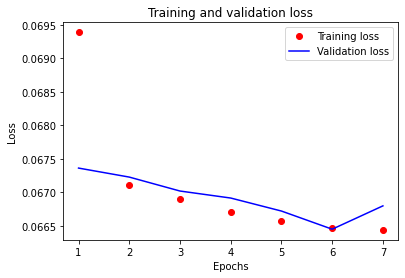

In [472]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [473]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(model.predict(X_test_array), y_test)
m.result().numpy()

0.25652334

This is an encouraging result. Let's see how the model predictions are.

In [ ]:
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [495]:
df_movies[(df_movies['user']==X_test_array[0][2])&(df_movies['film_id']==X_test_array[1][2])]

,rating,film_id,link,title,user,rating_pct,type
42737,40,2565,https://www.criticker.com/film/Riding-the-Bullet/,Riding the Bullet,64095,0.185417,film


In [488]:
model.predict(X_test_array)

array([[0.42251122],
       [0.4615071 ],
       [0.21999559],
       ...,
       [0.60202974],
       [0.50887746],
       [0.5142417 ]], dtype=float32)

The model predicted 0.19, the user rated it 0.22, so very close. How about another. 

In [531]:
df_movies[(df_movies['user']==X_test_array[0][0])&(df_movies['film_id']==X_test_array[1][0])]

,rating,film_id,link,title,user,rating_pct,type
436352,19,29950,https://www.criticker.com/film/Surf-School/,Surf School,75079,0.071368,film


This time the model predicted 0.43 and the user rated it 0.07, so way off.

We can try looking at the X_val_array.

In [534]:
df_movies[(df_movies['user']==X_val_array[0][2])&(df_movies['film_id']==X_val_array[1][2])]

,rating,film_id,link,title,user,rating_pct,type
442876,3,18033,https://www.criticker.com/film/Strings-2004/,Strings,51021,0.734553,film


In [500]:
model.predict(X_val_array)[:10]

array([[0.68257225],
       [0.36119646],
       [0.55298316],
       [0.4615071 ],
       [0.6335916 ],
       [0.63595545],
       [0.4615071 ],
       [0.4615071 ],
       [0.63254297],
       [0.4615071 ]], dtype=float32)

The model guessed 0.73 but the user rated it 0.55, so pretty close.

The following shows the RMSE for the X_val_array, and we can see more of the model's predictions in the dataframe below.

In [503]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(model.predict(X_val_array[0]), y_val)
m.result().numpy()

0.25642964

In [651]:
pivot_table[51021]

user
1297.0      0.0
1392.0      0.0
1481.0      0.0
1488.0      0.0
1496.0      0.0
           ... 
259167.0    0.0
261636.0    0.0
262800.0    0.0
263429.0    0.0
264502.0    0.0
Name: 51021.0, Length: 2159, dtype: float64

In [522]:
dftest = pd.DataFrame(model.predict(X_val_array))

In [524]:
dftest['y'] = y_val

In [527]:
dftest['diff'] = dftest[0]-dftest['y']

In [528]:
dftest[:20]

,0,y,diff
0,0.682572,0.753646,-0.071074
1,0.361196,0.017708,0.343488
2,0.552983,0.734553,-0.181570
3,0.461507,0.094444,0.367063
4,0.633592,0.274603,0.358988
5,0.635955,0.559394,0.076562
6,0.461507,0.892751,-0.431244
7,0.461507,0.399020,0.062488
8,0.632543,0.636806,-0.004263
9,0.461507,0.215064,0.246443


In [536]:
np.abs(dftest['diff']).mean()

0.21552973595480246

So the average difference between the prediction and the actual user rating is 0.22. Not bad.

A scatter plot of the first 500 valuation values and their predictions is below. 

In [541]:
px.scatter(dftest[:500], x=0, y='y')

In [546]:
dftest = dftest.rename(columns={0:'0'})

<AxesSubplot:xlabel='0', ylabel='y'>

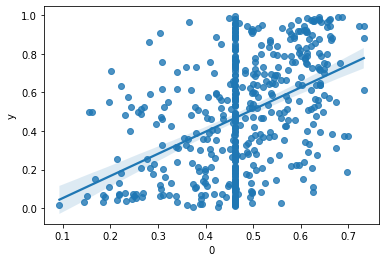

In [549]:
sns.regplot(data=dftest[:500], x='0', y='y')

Plotting a linear regression plot. This looks promising.

NB. There is a strange repeat of a movie rating here discovered by chance. Further investigation shows 

In [553]:
df_movies[(df_movies['user']==X_val_array[0][0])&(df_movies['film_id']==X_val_array[1][0])]

,rating,film_id,link,title,user,rating_pct,type
625641,86,1841,https://www.criticker.com/film/The-Lord-of-the...,The Lord of the Rings: The Return of the King,6722,0.753646,film
854856,90,1841,https://www.criticker.com/film/The-Lord-of-the...,The Lord of the Rings: The Return of the King,6722,0.879687,film


In [562]:
(len(df[df['user']==6722])-len(df[df['user']==6722].drop_duplicates('film_id')))/len(df[df['user']==6722])

0.5

In [563]:
len(df[df['user']==6722])

960

In [564]:
len(df[df['user']==6722].drop_duplicates('film_id'))

480

The user seems to have been scraped twice as the duplicate values are exactly half the total in the main dataframe. This should have been removed when we deleted the duplicates earlier. The strange thing is the rating is different. Maybe the user created 2 accounts but the user id should in theory be unique. Maybe further investigation is needed because if a duplicate although slightly different set of values is inside the training, testing and valuation sets then it could make it far easier for the model to predict what that user would rate a particular movie. 

### Updated ratings
Since I started this notebook the scraper has obtained more values. I will add them to a new dataframe here.

In [565]:
df3 = pd.read_csv('results.csv')

In [568]:
df3.isnull().sum()

rating     0
film_id    0
link       0
title      0
user       0
dtype: int64

In [569]:
df_new = df3.append(df2)

C:\Users\gkenn\AppData\Local\Temp\ipykernel_29792\401381036.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [570]:
df3['rating'] = df3['rating'].astype('int')
df3['user'] = df3['user'].astype('int')

In [580]:
len(df_new)-len(df_new.drop_duplicates())

106915

In [581]:
df_new = df_new.drop_duplicates()

In [588]:
print(len(df_new))
print(len(df_new['user'].unique()))

1502409
2159


We now have 1.5 million ratings from over 2000 unique users.

In [589]:
df_new['type'] = df_new['link'].str.split('/', expand=True)[3]

In [596]:
df_new.reset_index(drop=True, inplace=True)

In [597]:
df_new['rating_pct'] = 0

In [598]:
# for each user, calculate the percentile range of the ratings, then apply to the main dataframe
x = 0
while x < len(df_new['user'].unique()):
    df_new['rating_pct'][df_new[df_new['user']==df_new['user'].unique()[x]].index] = df_new[df_new['user']==df_new.user.unique()[x]]['rating'].rank(pct=True)
    x += 1

C:\Users\gkenn\AppData\Local\Temp\ipykernel_29792\680600164.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [718]:
df_new.to_csv('df_new.csv')

In [599]:
df_new_movies = df_new[df_new['type']=='film']

In [717]:
df_new_movies.to_csv('df_new_movies.csv')

In [600]:
X = df_new_movies[['user', 'film_id']].values
y = df_new_movies['rating_pct'].values

In [601]:
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.1)

In [602]:
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1)

In [603]:
e_dimension = 200

In [604]:
X_train_array = [X_train[:, 0], X_train[:,1]]
X_val_array = [X_val[:, 0], X_val[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [620]:
user = Input(shape=(1,))
u = Embedding(df_new_movies['user'].nunique(), e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-7))(user) # embedding was 1e-6
u = Reshape((e_dimension,))(u)
movie = Input(shape=(1,))
m = Embedding(df_new_movies['film_id'].nunique(), e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-7))(movie)  # embedding was 1e-6
m = Reshape((e_dimension,))(m)

x = Dot(axes=1)([u, m])
## new : concat user, id along with dot
x = Concatenate()([u, m,x])
x = Dropout(0.2)(x)

# Build last deep learning layers 
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
x = Dense(1)(x)

model = Model(inputs=[user, movie], outputs=x)
model.compile(loss='mean_squared_error', 
              optimizer='adam',  ## 0.001
              metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )

# Set up for early stop if the validation loss stop improving for more than 1 epoch
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=1,
                                                ),
                  # Saves the weights after every epoch
                  keras.callbacks.ModelCheckpoint(  
                      filepath='Model_1',
                      monitor='val_loss',
                      save_best_only=True,
                      )]

# Print model info summary
model.summary()  

history = model.fit(x=X_train_array, y=y_train, batch_size=64,
                    epochs=5, # 20
                    verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=(X_val_array, y_val)
                    )

# Save the model (we should make a good habit of always saving our models after training)
model.save("Model_1")

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 200)       431800      input_9[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 200)       12768600    input_10[0][0]                   
____________________________________________________________________________________________

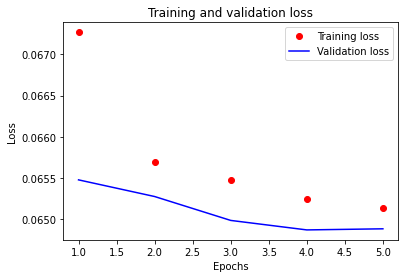

In [621]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [622]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(model.predict(X_test_array), y_test)
m.result().numpy()

0.25272503

This shows marginally improved results. Let's check the scatter plot for the first 500.

In [623]:
dftest = pd.DataFrame(model.predict(X_val_array))
dftest['y'] = y_val

In [624]:
px.scatter(dftest[:500], x=0, y='y')

<AxesSubplot:xlabel='0', ylabel='y'>

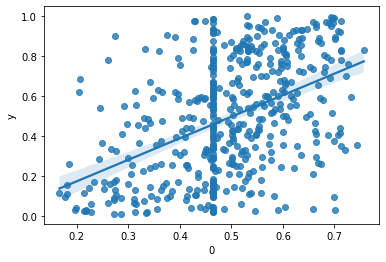

In [625]:
dftest = dftest.rename(columns={0:'0'})

sns.regplot(data=dftest[:500], x='0', y='y')

We might like to try splitting the scores into bins, with 1-10, 11-20, 21-30, and seeing how that works.

# Hybrid of rating score and rating_pct
An attempt to create a hybrid of the original rating score and the new rating percentile.

We need to fix the problem of user's using different scoring systems, eg. 1-5, 1-10, 1-100.

In [608]:
len(df_new_movies)

1418536

In [ ]:
df_new_movies['rating_combined']

Here you can see the user's max rating is 5. So their scoring system is only 1-5. We cannot compare a score of 5 (outstanding movie) from this user with a score of 5 from another user on a 1-100 system who thinks the movie was awful.

In [614]:
df_new_movies[df_new_movies['user']==51021]['rating'].max()

5.0

# Trying other machine learning techniques
We will use the model K Nearest Neighbors to find the closest matches to a user's profile of ratings and then print out the top 10 movies the closest matching user likes with their ratings.

In [631]:
pivot_table = pd.pivot_table(df_new_movies, index = ["user"], columns = ["film_id"], values = "rating_pct", fill_value=0, dropna=True)
print(pivot_table)

film_id   1.0       2.0       3.0       4.0       5.0       7.0       \
user                                                                   
1297.0    0.000000       0.0  0.918651       0.0       0.0       0.0   
1392.0    0.000000       0.0  0.000000       0.0       0.0       0.0   
1481.0    0.000000       0.0  0.000000       0.0       0.0       0.0   
1488.0    0.000000       0.0  0.000000       0.0       0.0       0.0   
1496.0    0.000000       0.0  0.188333       0.0       0.0       0.0   
...            ...       ...       ...       ...       ...       ...   
259167.0  0.430769       0.0  0.448846       0.0       0.0       0.0   
261636.0  0.000000       0.0  0.208854       0.0       0.0       0.0   
262800.0  0.000000       0.0  0.807692       0.0       0.0       0.0   
263429.0  0.000000       0.0  0.000000       0.0       0.0       0.0   
264502.0  0.000000       0.0  0.458333       0.0       0.0       0.0   

film_id   8.0       9.0       10.0      12.0      ...  219025.0

In [636]:
def findksimilarusers(user_id, pivot_ratings, k=50):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = cosine, algorithm = 'brute') 
    model_knn.fit(pivot_ratings)

    distances, indices = model_knn.kneighbors(pivot_ratings.loc[user_id].values.reshape(1, -1), n_neighbors = k+1)
    print(distances)
    print(indices)
    print(indices.shape)
    print(indices.flatten().shape)
    similarities = 1-distances.flatten()
    print(similarities)
    print(indices.flatten())
    print(similarities.shape)
    print(len(indices.flatten()))
    print(indices.flatten()[1])
    print ('{0} most similar users for User {1}:\n'.format(k,user_id))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_id:
            continue;

        else:
            print ('{0}: User {1}, with similarity of {2}'.format(i, indices.flatten()[i], similarities[i]))
            
    return similarities,indices

similarities, indices = findksimilarusers(51021, pivot_table)

[[0.         0.57384216 0.57914445 0.58001277 0.58648254 0.59208949
  0.59213018 0.59252983 0.59388096 0.59851181 0.59947148 0.6035836
  0.60400819 0.60433298 0.60712567 0.61292401 0.61358577 0.61454507
  0.61719328 0.62079945 0.62196169 0.62423633 0.62456051 0.62466904
  0.62647887 0.62724621 0.62911471 0.63035598 0.63092696 0.63111786
  0.63143571 0.63168915 0.63370445 0.63379294 0.63494556 0.6352366
  0.63566591 0.63740395 0.63805266 0.63875143 0.63968941 0.63985327
  0.6403087  0.64060072 0.6411032  0.64222049 0.64232201 0.64359114
  0.6436282  0.64367859 0.64393127]]
[[1278  113 2154 2058 1916  613 2068  677  847  808 1391  959 1375  920
  1469 1437 1317 1572  256  499 1241 1632  178   93 1454  136 1431 1166
   785 1603  209 1674  527  991 1174  491  384 1496  100 1513 1713  427
   152  496  448  665  795  822  315 1401 1569]]
(1, 51)
(51,)
[1.         0.42615784 0.42085555 0.41998723 0.41351746 0.40791051
 0.40786982 0.40747017 0.40611904 0.40148819 0.40052852 0.3964164
 0.395991

In [681]:
pivot_table.loc[2154].sort_values().tail(10).index

Float64Index([1979.0, 4219.0, 1671.0, 1670.0, 2156.0, 2603.0, 11328.0, 2339.0,
              962.0, 1801.0],
             dtype='float64', name='film_id')

This is a user in the list of top matching, let's see their top movies.

In [668]:
df_new_movies[df_new_movies['film_id']==1801]['title'][:1].item()

'The Life Aquatic with Steve Zissou'

In [682]:
[print(df_new_movies[df_new_movies['film_id']==x]['title'][:1].item()) for x in pivot_table.loc[2154].sort_values().tail(10).index]

The Matrix
V for Vendetta
Kill Bill: Volume 2
Kill Bill: Volume 1
Napoleon Dynamite
The Royal Tenenbaums
The Prestige
The Passion of the Christ
Star Wars: Episode V - The Empire Strikes Back
The Life Aquatic with Steve Zissou


[None, None, None, None, None, None, None, None, None, None]

In [677]:
[print(x) for x in pivot_table.loc[2154].sort_values().tail(10).items()]

(1979.0, 0.9881578947368421)
(4219.0, 0.9881578947368421)
(1671.0, 0.9881578947368421)
(1670.0, 0.9881578947368421)
(2156.0, 0.9881578947368421)
(2603.0, 0.9881578947368421)
(11328.0, 0.9881578947368421)
(2339.0, 0.9881578947368421)
(962.0, 0.9881578947368421)
(1801.0, 0.9881578947368421)


[None, None, None, None, None, None, None, None, None, None]

In [684]:
# asking user
df_new_movies[df_new_movies['user']==51021]

,rating,film_id,link,title,user,type,rating_pct
441118,5.0,94031.0,https://www.criticker.com/film/20000-Days-on-E...,"20,000 Days on Earth",51021.0,film,0.988821
441119,5.0,3492.0,https://www.criticker.com/film/2001-A-Space-Od...,2001: A Space Odyssey,51021.0,film,0.988821
441120,5.0,3499.0,https://www.criticker.com/film/28-Days-Later/,28 Days Later,51021.0,film,0.988821
441121,5.0,3.0,https://www.criticker.com/film/AI-Artificial-I...,A.I. Artificial Intelligence,51021.0,film,0.988821
441122,5.0,4634.0,https://www.criticker.com/film/Aguirre-The-Wra...,Aguirre: The Wrath of God,51021.0,film,0.988821
...,...,...,...,...,...,...,...
446030,0.0,125111.0,https://www.criticker.com/film/xXx-Return-of-X...,xXx: Return of Xander Cage,51021.0,film,0.041768
446031,0.0,3437.0,https://www.criticker.com/film/xXx-State-of-th...,xXx: State of the Union,51021.0,film,0.041768
446032,0.0,86368.0,https://www.criticker.com/film/Young-Detective...,Young Detective Dee: Rise of the Sea Dragon,51021.0,film,0.041768
446035,0.0,74766.0,https://www.criticker.com/film/Zero-Dark-Thirty/,Zero Dark Thirty,51021.0,film,0.041768


In [685]:
# recommended user
df_new_movies[df_new_movies['user']==2154]

,rating,film_id,link,title,user,type,rating_pct
194639,100.0,4314.0,https://www.criticker.com/film/Ace-Ventura-Pet...,Ace Ventura: Pet Detective,2154.0,film,0.988158
194640,100.0,695.0,https://www.criticker.com/film/The-Count-of-Mo...,The Count of Monte Cristo,2154.0,film,0.988158
194641,100.0,11177.0,https://www.criticker.com/film/The-Departed/,The Departed,2154.0,film,0.988158
194642,100.0,917.0,https://www.criticker.com/film/Dumb-and-Dumber/,Dumb and Dumber,2154.0,film,0.988158
194643,100.0,979.0,https://www.criticker.com/film/Equilibrium/,Equilibrium,2154.0,film,0.988158
...,...,...,...,...,...,...,...
195774,62.0,751.0,https://www.criticker.com/film/Dancing-at-the-...,Dancing at the Blue Iguana,2154.0,film,0.004386
195775,60.0,242.0,https://www.criticker.com/film/Barbershop/,Barbershop,2154.0,film,0.002193
195776,60.0,518.0,https://www.criticker.com/film/Cabin-Fever/,Cabin Fever,2154.0,film,0.002193
195777,60.0,547.0,https://www.criticker.com/film/Catwoman/,Catwoman,2154.0,film,0.002193


# pickle

In [692]:
model.save('')

INFO:tensorflow:Assets written to: assets


In [694]:
model_reloaded = keras.models.load_model('')

In [695]:
model_reloaded.predict(X_val_array)[:10]

array([[0.5021249 ],
       [0.6684747 ],
       [0.4316396 ],
       [0.32035473],
       [0.6843556 ],
       [0.44774774],
       [0.4643977 ],
       [0.4586631 ],
       [0.34746858],
       [0.55839145]], dtype=float32)

In [701]:
df_movies[(df_movies['user']==X_val_array[0][2])&(df_movies['film_id']==X_val_array[1][2])]

,rating,film_id,link,title,user,rating_pct,type
166095,50,32912,https://www.criticker.com/film/For-Hire/,For Hire,49233,0.103226,film


In [696]:
model.predict(X_val_array)[:10]

array([[0.5021249 ],
       [0.6684747 ],
       [0.4316396 ],
       [0.32035473],
       [0.6843556 ],
       [0.44774774],
       [0.4643977 ],
       [0.4586631 ],
       [0.34746858],
       [0.55839145]], dtype=float32)

In [706]:
print(X_val_array[0])
print(len(X_val_array[0]))

[ 38669.  19204.  49233. ...  34854. 233267.   3665.]
127669


In [707]:
print(X_val_array[1])
print(len(X_val_array[1]))

[30768.  7059. 32912. ... 27427.   540.  3313.]
127669


### so the model is used here to make predictions for existing users and if they will like other movies based on similar user's ratings
#####  it is possible to predict by completely new user. X_test and X_val are outside of the model. so can add new user into the model.predict

In [ ]:
def recommendations(user_id, similarities, indices):
    actual_indices = [x for x in indices.flatten()]
#    print(actual_indices)
    sim_ind = dict(zip(actual_indices, similarities))
    #print(sim_ind)

    #del sim_ind[user_id-1]
    print(sim_ind)
    max_ind = [key for m in [max(sim_ind.values())] for key,val in sim_ind.items() if val == m]
    #print(max_ind)
    
    for maxSim_row in max_ind:
        similarUser = pivot_table.loc[maxSim_row,:]
        currUser = pivot_table.loc[user_id,:]   
#        print(currUser)
#        print(similarUser)
        currUser_zeros = currUser[currUser==0]
        print(currUser_zeros)
        for k in currUser_zeros.keys():
            if similarUser[k] != 0:
                print('Recommendations for User {0}: {1}'.format(user_id, k))
recommendations(51021, similarities, indices)

In [ ]:
x = (pivot_table.loc[4]).values.reshape(1,-1)
y = (pivot_table.loc[38500]).values.reshape(1,-1)
print(x.shape)
print(y.shape)
print(sklearn.metrics.pairwise.cosine_similarity(x,y))

In [708]:
!jupyter nbconvert --to webpdf "criticker analysis.ipynb"

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook criticker analysis.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 916614 bytes to criticker analysis.pdf


In [712]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [715]:
!jupyter nbconvert --to html "criticker analysis.ipynb"

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook criticker analysis.ipynb to html
[NbConvertApp] Writing 1014005 bytes to criticker analysis.html


In [156]:
#data = df5[['Population (historical estimates)', 'Arable land (% of land area)']]
data = df5['Arable land (% of land area)'].values

In [312]:
from sklearn.impute import SimpleImputer

In [158]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [159]:
#data_no_na = imp.fit_transform(data)
data_no_na = imp.fit_transform(data.reshape(-1,1))

In [160]:
scaled_data = scaler.fit_transform(data_no_na)

In [161]:
kmeans.fit(scaled_data)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



KMeans(n_clusters=4)

In [81]:
from sklearn.preprocessing import StandardScaler

In [82]:
scaler = StandardScaler()

In [85]:
data2 = df5['Pupil-teacher ratio, preprimary'].values

In [84]:
scaled1 = scaler.fit_transform(data.reshape(-1,1))

In [86]:
scaled2 = scaler.fit_transform(data2.reshape(-1,1))

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)